# The Mathematical Foundations of Latent Factor Models
## A Numerical Tutorial with Matrix Factorization (MF) and Bayesian Personalized Ranking (BPR)

This notebook provides a comprehensive, hands-on demonstration of two fundamental latent factor models used in recommender systems:

1. **Matrix Factorization (MF)**: Learns to predict missing user-item interactions by decomposing the interaction matrix into lower-rank user and item latent factor matrices.

2. **Bayesian Personalized Ranking (BPR)**: Optimizes for pairwise ranking by learning to order items based on user preferences.

We will use a concrete numerical example with **7 users** and **8 items** to demonstrate these concepts in clear numerical terms, not just mathematical symbols.

---
## Key Mathematical Concepts

### Matrix Factorization
- **Interaction Matrix**: $R \in \mathbb{R}^{M \times N}$ (sparse)
- **User Latent Factors**: $P \in \mathbb{R}^{M \times K}$
- **Item Latent Factors**: $Q \in \mathbb{R}^{N \times K}$
- **Prediction**: $\hat{r}_{ui} = p_u^T q_i$
- **Loss**: $J = \sum_{(u,i) \in \mathcal{K}} (r_{ui} - p_u^T q_i)^2 + \lambda(\|P\|_F^2 + \|Q\|_F^2)$

### Bayesian Personalized Ranking
- **Triplets**: $D_S = \{(u, i, j) \mid i \in R_u^+ \land j \in I \setminus R_u^+\}$
- **Pairwise Probability**: $p(i >_u j) = \sigma(\hat{x}_{ui} - \hat{x}_{uj})$
- **BPR Loss**: $L_{BPR} = -\sum_{(u,i,j)} \ln \sigma(\hat{x}_{ui} - \hat{x}_{uj}) + \lambda\|\Theta\|^2$

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 1.26.4


## 2. Create Synthetic User-Item Interaction Matrix

We create a sparse interaction matrix $R \in \mathbb{R}^{7 \times 8}$ representing 7 users and 8 items.

- **Users**: U1, U2, U3, U4, U5, U6, U7
- **Items**: I1, I2, I3, I4, I5, I6, I7, I8
- **Ratings**: 1-5 scale (explicit feedback)
- **Sparsity**: ~30% of entries are observed (realistic for real-world datasets)

The challenge: **Predict the missing entries!**

In [ ]:
# Define dimensions
M = 7  # Number of users
N = 8  # Number of items
users = [f'U{i+1}' for i in range(M)]
items = [f'I{i+1}' for i in range(N)]

# Create a sparse user-item interaction matrix R
# We'll manually create a realistic pattern with ~30% observed entries
R = np.array([
    [5, 0, 4, 0, 0, 3, 0, 2],   # U1: likes I1, I3, I6, I8
    [0, 4, 0, 5, 0, 0, 3, 0],   # U2: likes I2, I4, I7
    [3, 0, 0, 4, 5, 0, 0, 0],   # U3: likes I1, I4, I5
    [0, 0, 5, 0, 4, 0, 0, 3],   # U4: likes I3, I5, I8
    [4, 3, 0, 0, 0, 5, 0, 0],   # U5: likes I1, I2, I6
    [0, 0, 0, 3, 0, 4, 5, 0],   # U6: likes I4, I6, I7
    [0, 5, 4, 0, 0, 0, 0, 4],   # U7: likes I2, I3, I8
], dtype=float)

# Create mask for observed entries (1 = observed, 0 = missing)
mask = (R != 0).astype(float)
 
# Calculate sparsity statistics
total_entries = M * N
observed_entries = np.sum(mask)
sparsity = 1 - (observed_entries / total_entries)

print("=" * 60)
print("USER-ITEM INTERACTION MATRIX R")
print("=" * 60)
print(f"\nMatrix Shape: {M} users × {N} items = {total_entries} total entries")
print(f"Observed Entries: {int(observed_entries)} ({100*(1-sparsity):.1f}%)")
print(f"Missing Entries: {int(total_entries - observed_entries)} ({100*sparsity:.1f}%)")
print("\nInteraction Matrix R (0 = missing/unobserved):")
print("-" * 60)

# Print matrix with labels
print("      ", end="")
for item in items:
    print(f"{item:>6}", end="")
print()
print("      " + "-" * 48)

for i, user in enumerate(users):
    print(f"{user:>5} |", end="")
    for j in range(N):
        if R[i, j] == 0:
            print(f"{'?':>6}", end="")
        else:
            print(f"{int(R[i, j]):>6}", end="")
    print()

print("\n" + "=" * 60)

USER-ITEM INTERACTION MATRIX R

Matrix Shape: 7 users × 8 items = 56 total entries
Observed Entries: 22 (39.3%)
Missing Entries: 34 (60.7%)

Interaction Matrix R (0 = missing/unobserved):
------------------------------------------------------------
          I1    I2    I3    I4    I5    I6    I7    I8
      ------------------------------------------------
   U1 |     5     ?     4     ?     ?     3     ?     2
   U2 |     ?     4     ?     5     ?     ?     3     ?
   U3 |     3     ?     ?     4     5     ?     ?     ?
   U4 |     ?     ?     5     ?     4     ?     ?     3
   U5 |     4     3     ?     ?     ?     5     ?     ?
   U6 |     ?     ?     ?     3     ?     4     5     ?
   U7 |     ?     5     4     ?     ?     ?     ?     4



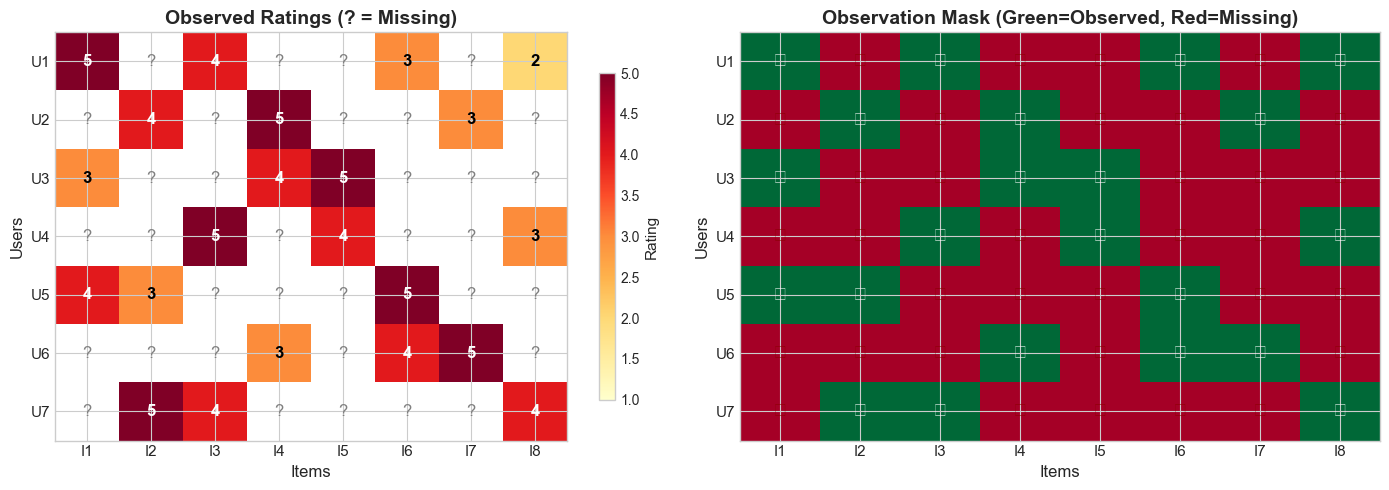


📊 The goal of Matrix Factorization: Predict the 34 missing entries!


In [3]:
# Visualize the interaction matrix as a heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create custom colormap for ratings
colors_rating = ['#f0f0f0', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
cmap_rating = LinearSegmentedColormap.from_list('rating', colors_rating)

# Left: Original matrix with missing values shown differently
ax1 = axes[0]
# Create a masked array for visualization
R_viz = np.ma.masked_where(R == 0, R)
im1 = ax1.imshow(R_viz, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax1.set_xticks(range(N))
ax1.set_yticks(range(M))
ax1.set_xticklabels(items, fontsize=11)
ax1.set_yticklabels(users, fontsize=11)
ax1.set_title('Observed Ratings (? = Missing)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Items', fontsize=12)
ax1.set_ylabel('Users', fontsize=12)

# Add text annotations
for i in range(M):
    for j in range(N):
        if R[i, j] == 0:
            ax1.text(j, i, '?', ha='center', va='center', fontsize=12, color='gray')
        else:
            ax1.text(j, i, f'{int(R[i, j])}', ha='center', va='center', 
                    fontsize=12, fontweight='bold', color='white' if R[i, j] >= 4 else 'black')

cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Rating', fontsize=11)

# Right: Binary mask showing observed vs missing
ax2 = axes[1]
im2 = ax2.imshow(mask, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(range(N))
ax2.set_yticks(range(M))
ax2.set_xticklabels(items, fontsize=11)
ax2.set_yticklabels(users, fontsize=11)
ax2.set_title('Observation Mask (Green=Observed, Red=Missing)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Items', fontsize=12)
ax2.set_ylabel('Users', fontsize=12)

# Add text annotations
for i in range(M):
    for j in range(N):
        text = '✓' if mask[i, j] == 1 else '✗'
        color = 'white' if mask[i, j] == 1 else 'darkred'
        ax2.text(j, i, text, ha='center', va='center', fontsize=14, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 The goal of Matrix Factorization: Predict the {int(total_entries - observed_entries)} missing entries!")

## 3. Matrix Factorization Implementation

### The Core Idea
Matrix Factorization decomposes the sparse matrix $R$ into two lower-rank matrices:
- **User matrix** $P \in \mathbb{R}^{M \times K}$: Each row $p_u$ represents user $u$'s affinity for $K$ latent features
- **Item matrix** $Q \in \mathbb{R}^{N \times K}$: Each row $q_i$ represents how much item $i$ possesses those features

### Prediction Formula
$$\hat{r}_{ui} = p_u^T q_i = \sum_{k=1}^{K} p_{uk} \cdot q_{ik}$$

### Regularized Loss Function
$$J = \underbrace{\sum_{(u,i) \in \mathcal{K}} (r_{ui} - p_u^T q_i)^2}_{\text{Reconstruction Error}} + \underbrace{\lambda \left(\|P\|_F^2 + \|Q\|_F^2\right)}_{\text{Regularization}}$$

We'll use **K=3 latent factors** for this example.

In [4]:
# Matrix Factorization Parameters
K = 3  # Number of latent factors

# Initialize P and Q with small random values (Gaussian initialization)
np.random.seed(42)
P = np.random.randn(M, K) * 0.5  # User latent factors (7 × 3)
Q = np.random.randn(N, K) * 0.5  # Item latent factors (8 × 3)

print("=" * 70)
print("INITIAL LATENT FACTOR MATRICES")
print("=" * 70)

print(f"\n📌 User Latent Factor Matrix P ∈ ℝ^({M}×{K}):")
print("   Each row represents a user's affinity for {K} latent features")
print("-" * 70)
print("        Factor1   Factor2   Factor3")
print("        " + "-" * 30)
for i, user in enumerate(users):
    print(f"{user:>5}  [{P[i,0]:+8.4f}, {P[i,1]:+8.4f}, {P[i,2]:+8.4f}]")

print(f"\n📌 Item Latent Factor Matrix Q ∈ ℝ^({N}×{K}):")
print("   Each row represents how much an item possesses each latent feature")
print("-" * 70)
print("        Factor1   Factor2   Factor3")
print("        " + "-" * 30)
for i, item in enumerate(items):
    print(f"{item:>5}  [{Q[i,0]:+8.4f}, {Q[i,1]:+8.4f}, {Q[i,2]:+8.4f}]")

print("\n" + "=" * 70)

INITIAL LATENT FACTOR MATRICES

📌 User Latent Factor Matrix P ∈ ℝ^(7×3):
   Each row represents a user's affinity for {K} latent features
----------------------------------------------------------------------
        Factor1   Factor2   Factor3
        ------------------------------
   U1  [ +0.2484,  -0.0691,  +0.3238]
   U2  [ +0.7615,  -0.1171,  -0.1171]
   U3  [ +0.7896,  +0.3837,  -0.2347]
   U4  [ +0.2713,  -0.2317,  -0.2329]
   U5  [ +0.1210,  -0.9566,  -0.8625]
   U6  [ -0.2811,  -0.5064,  +0.1571]
   U7  [ -0.4540,  -0.7062,  +0.7328]

📌 Item Latent Factor Matrix Q ∈ ℝ^(8×3):
   Each row represents how much an item possesses each latent feature
----------------------------------------------------------------------
        Factor1   Factor2   Factor3
        ------------------------------
   I1  [ -0.1129,  +0.0338,  -0.7124]
   I2  [ -0.2722,  +0.0555,  -0.5755]
   I3  [ +0.1878,  -0.3003,  -0.1458]
   I4  [ -0.3009,  +0.9261,  -0.0067]
   I5  [ -0.5289,  +0.4113,  -0.6104]
  

In [5]:
# Define prediction and loss functions

def predict_mf(P, Q):
    """Compute predicted ratings: R_hat = P @ Q.T"""
    return P @ Q.T

def compute_mse_loss(R, P, Q, mask, lambda_reg):
    """
    Compute regularized MSE loss:
    J = sum((r - r_hat)^2) + lambda * (||P||^2 + ||Q||^2)
    """
    R_hat = predict_mf(P, Q)
    # Only compute loss on observed entries
    reconstruction_error = np.sum(mask * (R - R_hat) ** 2)
    regularization = lambda_reg * (np.sum(P ** 2) + np.sum(Q ** 2))
    return reconstruction_error + regularization

def compute_rmse(R, P, Q, mask):
    """Compute RMSE only on observed entries"""
    R_hat = predict_mf(P, Q)
    mse = np.sum(mask * (R - R_hat) ** 2) / np.sum(mask)
    return np.sqrt(mse)

# Demonstrate prediction for a specific user-item pair
print("=" * 70)
print("PREDICTION EXAMPLE: Computing r̂(U1, I1)")
print("=" * 70)

u, i = 0, 0  # U1, I1
p_u = P[u]
q_i = Q[i]

print(f"\n📍 User U1's latent vector p_u = [{p_u[0]:+.4f}, {p_u[1]:+.4f}, {p_u[2]:+.4f}]")
print(f"📍 Item I1's latent vector q_i = [{q_i[0]:+.4f}, {q_i[1]:+.4f}, {q_i[2]:+.4f}]")

print(f"\n🔢 Dot Product Calculation:")
print(f"   r̂(U1, I1) = p_u · q_i")
print(f"            = ({p_u[0]:+.4f})×({q_i[0]:+.4f}) + ({p_u[1]:+.4f})×({q_i[1]:+.4f}) + ({p_u[2]:+.4f})×({q_i[2]:+.4f})")
products = [p_u[k] * q_i[k] for k in range(K)]
print(f"            = {products[0]:+.4f} + {products[1]:+.4f} + {products[2]:+.4f}")
print(f"            = {sum(products):.4f}")
print(f"\n✅ Actual rating r(U1, I1) = {int(R[u, i])}")
print(f"❌ Initial prediction error = |{R[u, i]:.0f} - {sum(products):.4f}| = {abs(R[u, i] - sum(products)):.4f}")

# Compute initial loss
lambda_reg = 0.1
initial_loss = compute_mse_loss(R, P, Q, mask, lambda_reg)
initial_rmse = compute_rmse(R, P, Q, mask)

print(f"\n📊 Initial Loss (λ={lambda_reg}):")
print(f"   Total Loss J = {initial_loss:.4f}")
print(f"   RMSE on observed = {initial_rmse:.4f}")
print("\n" + "=" * 70)

PREDICTION EXAMPLE: Computing r̂(U1, I1)

📍 User U1's latent vector p_u = [+0.2484, -0.0691, +0.3238]
📍 Item I1's latent vector q_i = [-0.1129, +0.0338, -0.7124]

🔢 Dot Product Calculation:
   r̂(U1, I1) = p_u · q_i
            = (+0.2484)×(-0.1129) + (-0.0691)×(+0.0338) + (+0.3238)×(-0.7124)
            = -0.0280 + -0.0023 + -0.2307
            = -0.2611

✅ Actual rating r(U1, I1) = 5
❌ Initial prediction error = |5 - -0.2611| = 5.2611

📊 Initial Loss (λ=0.1):
   Total Loss J = 357.7786
   RMSE on observed = 4.0270



## 4. Train Matrix Factorization Model

### Stochastic Gradient Descent (SGD) Update Rules

For each observed entry $(u, i)$ with rating $r_{ui}$:

1. **Compute prediction error**: $e_{ui} = r_{ui} - p_u^T q_i$

2. **Update user factors**:
$$p_u \leftarrow p_u + \eta \left( e_{ui} \cdot q_i - \lambda \cdot p_u \right)$$

3. **Update item factors**:
$$q_i \leftarrow q_i + \eta \left( e_{ui} \cdot p_u - \lambda \cdot q_i \right)$$

Where $\eta$ is the learning rate and $\lambda$ is the regularization strength.

In [6]:
def train_mf_sgd(R, mask, K, learning_rate=0.01, lambda_reg=0.1, n_epochs=1000, verbose_steps=3):
    """
    Train Matrix Factorization using SGD
    
    Returns: P, Q, loss_history, detailed_updates (for first few steps)
    """
    M, N = R.shape
    
    # Re-initialize for training
    np.random.seed(42)
    P = np.random.randn(M, K) * 0.5
    Q = np.random.randn(N, K) * 0.5
    
    # Get list of observed entries
    observed_indices = list(zip(*np.where(mask == 1)))
    
    loss_history = []
    detailed_updates = []
    
    for epoch in range(n_epochs):
        # Shuffle observed entries
        np.random.shuffle(observed_indices)
        
        for idx, (u, i) in enumerate(observed_indices):
            # Current prediction
            r_hat = np.dot(P[u], Q[i])
            
            # Prediction error
            e_ui = R[u, i] - r_hat
            
            # Store detailed update for first few iterations
            if epoch == 0 and idx < verbose_steps:
                detailed_updates.append({
                    'step': idx + 1,
                    'user': u,
                    'item': i,
                    'r_actual': R[u, i],
                    'r_pred': r_hat,
                    'error': e_ui,
                    'p_u_before': P[u].copy(),
                    'q_i_before': Q[i].copy(),
                })
            
            # Save old values for detailed update
            p_u_old = P[u].copy()
            q_i_old = Q[i].copy()
            
            # SGD update
            P[u] = P[u] + learning_rate * (e_ui * Q[i] - lambda_reg * P[u])
            Q[i] = Q[i] + learning_rate * (e_ui * p_u_old - lambda_reg * Q[i])
            
            if epoch == 0 and idx < verbose_steps:
                detailed_updates[-1]['p_u_after'] = P[u].copy()
                detailed_updates[-1]['q_i_after'] = Q[i].copy()
                detailed_updates[-1]['p_gradient'] = e_ui * q_i_old - lambda_reg * p_u_old
                detailed_updates[-1]['q_gradient'] = e_ui * p_u_old - lambda_reg * q_i_old
        
        # Compute loss at end of epoch
        loss = compute_mse_loss(R, P, Q, mask, lambda_reg)
        loss_history.append(loss)
    
    return P, Q, loss_history, detailed_updates

# Training parameters
learning_rate = 0.01
lambda_reg = 0.1
n_epochs = 1000

print("=" * 80)
print("TRAINING MATRIX FACTORIZATION WITH SGD")
print("=" * 80)
print(f"\n⚙️ Hyperparameters:")
print(f"   Learning rate (η) = {learning_rate}")
print(f"   Regularization (λ) = {lambda_reg}")
print(f"   Latent factors (K) = {K}")
print(f"   Epochs = {n_epochs}")

# Train the model
P_trained, Q_trained, loss_history, detailed_updates = train_mf_sgd(
    R, mask, K, learning_rate, lambda_reg, n_epochs, verbose_steps=3
)

print("\n" + "-" * 80)
print("📝 DETAILED SGD UPDATES (First 3 steps of Epoch 1)")
print("-" * 80)

for update in detailed_updates:
    u, i = update['user'], update['item']
    print(f"\n🔄 Step {update['step']}: Update for (U{u+1}, I{i+1})")
    print(f"   Actual rating r_{{{u+1},{i+1}}} = {update['r_actual']:.0f}")
    print(f"   Predicted r̂_{{{u+1},{i+1}}} = {update['r_pred']:.4f}")
    print(f"   Error e_{{{u+1},{i+1}}} = {update['r_actual']:.0f} - {update['r_pred']:.4f} = {update['error']:.4f}")
    
    print(f"\n   📍 p_u BEFORE: [{update['p_u_before'][0]:+.4f}, {update['p_u_before'][1]:+.4f}, {update['p_u_before'][2]:+.4f}]")
    print(f"   📍 q_i BEFORE: [{update['q_i_before'][0]:+.4f}, {update['q_i_before'][1]:+.4f}, {update['q_i_before'][2]:+.4f}]")
    
    grad_p = update['p_gradient']
    grad_q = update['q_gradient']
    print(f"\n   ∇p_u = e·q_i - λ·p_u = [{grad_p[0]:+.4f}, {grad_p[1]:+.4f}, {grad_p[2]:+.4f}]")
    print(f"   ∇q_i = e·p_u - λ·q_i = [{grad_q[0]:+.4f}, {grad_q[1]:+.4f}, {grad_q[2]:+.4f}]")
    
    print(f"\n   📍 p_u AFTER:  [{update['p_u_after'][0]:+.4f}, {update['p_u_after'][1]:+.4f}, {update['p_u_after'][2]:+.4f}]")
    print(f"   📍 q_i AFTER:  [{update['q_i_after'][0]:+.4f}, {update['q_i_after'][1]:+.4f}, {update['q_i_after'][2]:+.4f}]")

# Final statistics
final_rmse = compute_rmse(R, P_trained, Q_trained, mask)
print("\n" + "=" * 80)
print(f"✅ Training Complete!")
print(f"   Initial Loss: {loss_history[0]:.4f}")
print(f"   Final Loss: {loss_history[-1]:.4f}")
print(f"   Final RMSE: {final_rmse:.4f}")
print("=" * 80)

TRAINING MATRIX FACTORIZATION WITH SGD

⚙️ Hyperparameters:
   Learning rate (η) = 0.01
   Regularization (λ) = 0.1
   Latent factors (K) = 3
   Epochs = 1000

--------------------------------------------------------------------------------
📝 DETAILED SGD UPDATES (First 3 steps of Epoch 1)
--------------------------------------------------------------------------------

🔄 Step 1: Update for (U1, I8)
   Actual rating r_{1,8} = 2
   Predicted r̂_{1,8} = -0.2434
   Error e_{1,8} = 2 - -0.2434 = 2.2434

   📍 p_u BEFORE: [+0.2484, -0.0691, +0.3238]
   📍 q_i BEFORE: [-0.0578, -0.1506, -0.7393]

   ∇p_u = e·q_i - λ·p_u = [-0.1546, -0.3308, -1.6908]
   ∇q_i = e·p_u - λ·q_i = [+0.5629, -0.1400, +0.8004]

   📍 p_u AFTER:  [+0.2468, -0.0724, +0.3069]
   📍 q_i AFTER:  [-0.0522, -0.1520, -0.7313]

🔄 Step 2: Update for (U1, I3)
   Actual rating r_{1,3} = 4
   Predicted r̂_{1,3} = 0.0234
   Error e_{1,3} = 4 - 0.0234 = 3.9766

   📍 p_u BEFORE: [+0.2468, -0.0724, +0.3069]
   📍 q_i BEFORE: [+0.1878, -0

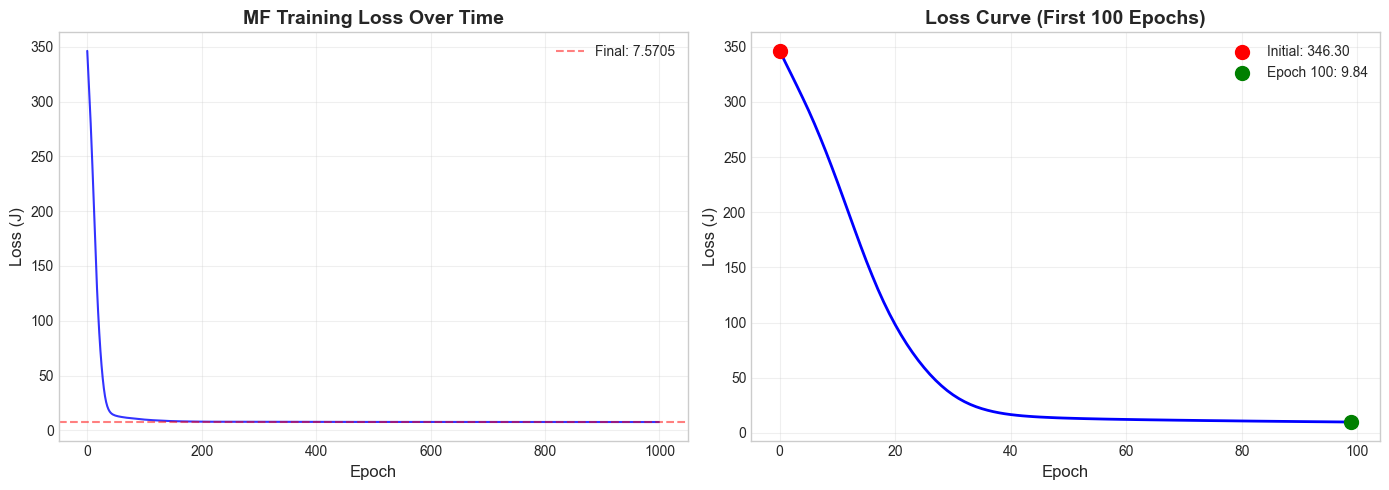

📉 Loss decreased by 97.8% during training


In [7]:
# Plot training loss curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full loss curve
ax1 = axes[0]
ax1.plot(loss_history, 'b-', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (J)', fontsize=12)
ax1.set_title('MF Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.axhline(y=loss_history[-1], color='r', linestyle='--', alpha=0.5, label=f'Final: {loss_history[-1]:.4f}')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Zoomed view of first 100 epochs
ax2 = axes[1]
ax2.plot(loss_history[:100], 'b-', linewidth=2)
ax2.scatter([0], [loss_history[0]], color='red', s=100, zorder=5, label=f'Initial: {loss_history[0]:.2f}')
ax2.scatter([99], [loss_history[99]], color='green', s=100, zorder=5, label=f'Epoch 100: {loss_history[99]:.2f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (J)', fontsize=12)
ax2.set_title('Loss Curve (First 100 Epochs)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📉 Loss decreased by {((loss_history[0] - loss_history[-1])/loss_history[0]*100):.1f}% during training")

## 5. Visualize MF Latent Factors and Predictions

Now let's examine:
1. The learned latent factor matrices $P$ and $Q$
2. Users and items plotted in the latent space
3. The reconstructed matrix $\hat{R}$ vs. the original $R$

In [8]:
# Display learned latent factors
print("=" * 70)
print("LEARNED LATENT FACTOR MATRICES")
print("=" * 70)

print(f"\n📌 Trained User Latent Factor Matrix P ∈ ℝ^({M}×{K}):")
print("-" * 70)
print("        Factor1   Factor2   Factor3")
print("        " + "-" * 30)
for i, user in enumerate(users):
    print(f"{user:>5}  [{P_trained[i,0]:+8.4f}, {P_trained[i,1]:+8.4f}, {P_trained[i,2]:+8.4f}]")

print(f"\n📌 Trained Item Latent Factor Matrix Q ∈ ℝ^({N}×{K}):")
print("-" * 70)
print("        Factor1   Factor2   Factor3")
print("        " + "-" * 30)
for i, item in enumerate(items):
    print(f"{item:>5}  [{Q_trained[i,0]:+8.4f}, {Q_trained[i,1]:+8.4f}, {Q_trained[i,2]:+8.4f}]")

LEARNED LATENT FACTOR MATRICES

📌 Trained User Latent Factor Matrix P ∈ ℝ^(7×3):
----------------------------------------------------------------------
        Factor1   Factor2   Factor3
        ------------------------------
   U1  [ +0.9711,  -0.7464,  -1.5161]
   U2  [ +0.4975,  +0.4680,  -2.1470]
   U3  [ +0.3957,  +0.6666,  -1.7662]
   U4  [ +0.6948,  -1.0242,  -1.9214]
   U5  [ +0.1452,  -1.9506,  -0.9203]
   U6  [ +0.6793,  -1.2354,  -1.5601]
   U7  [ -0.5248,  -1.1640,  -2.0000]

📌 Trained Item Latent Factor Matrix Q ∈ ℝ^(8×3):
----------------------------------------------------------------------
        Factor1   Factor2   Factor3
        ------------------------------
   I1  [ +1.0391,  -1.0765,  -1.8763]
   I2  [ -0.1655,  -0.6135,  -1.9968]
   I3  [ +0.7741,  -0.8970,  -1.6952]
   I4  [ +0.5944,  +0.4165,  -1.9777]
   I5  [ +0.5317,  +0.7607,  -2.2890]
   I6  [ +0.1090,  -1.9618,  -0.9499]
   I7  [ +0.7402,  -1.4752,  -1.5625]
   I8  [ -0.4960,  -0.9417,  -1.2178]


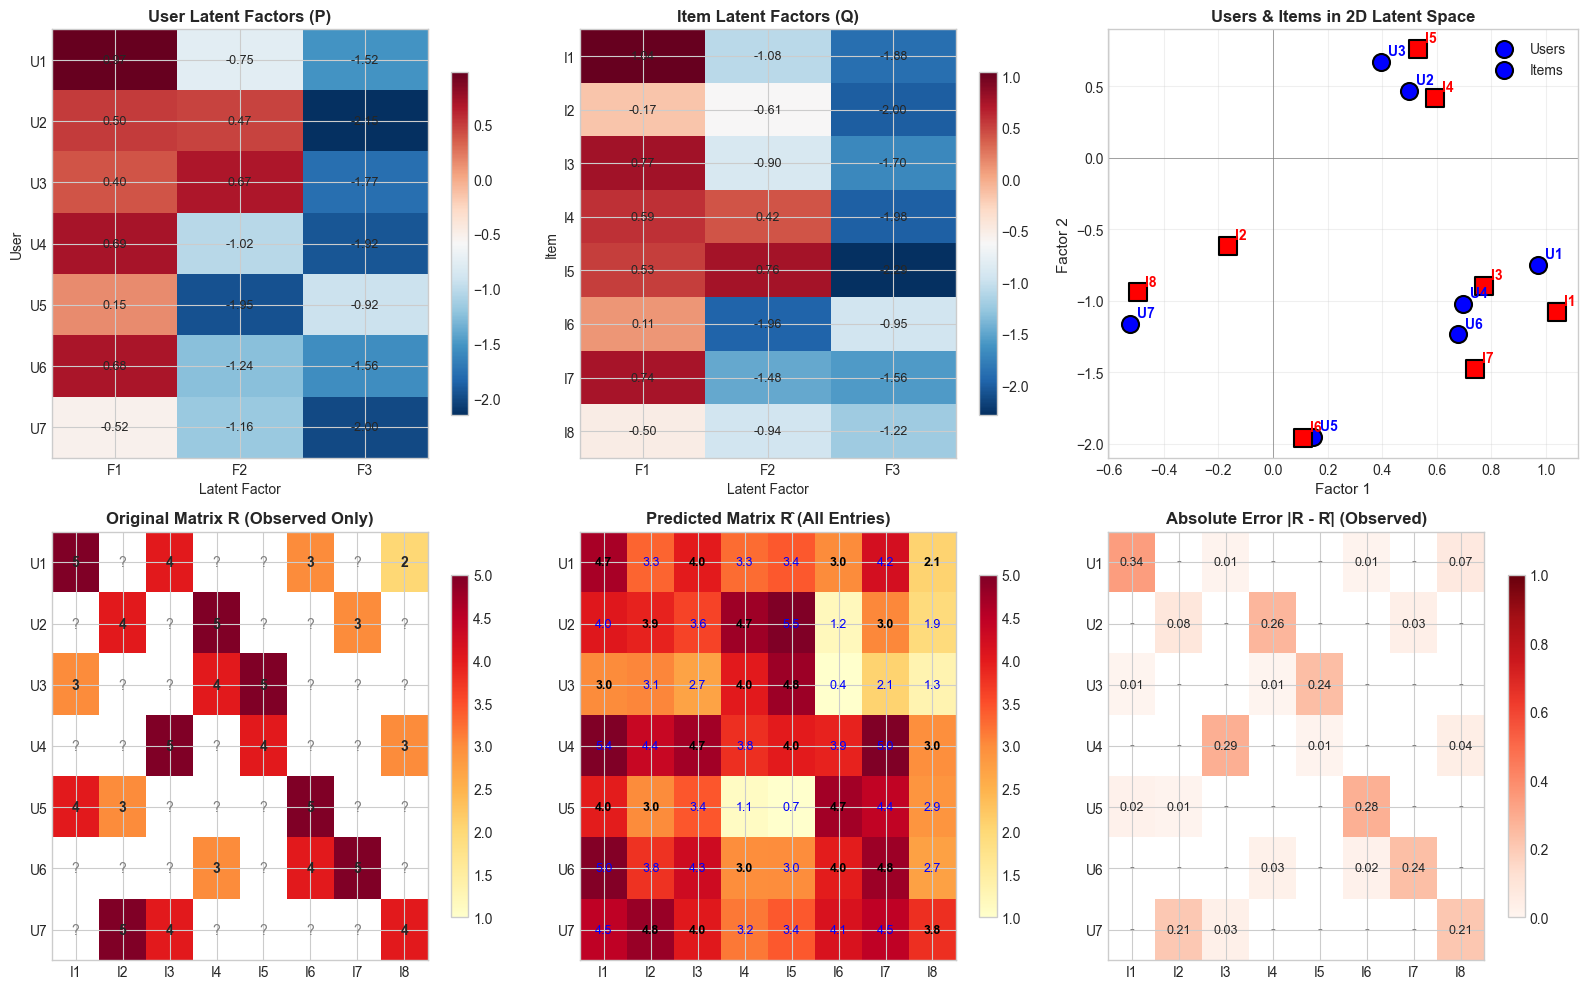


📊 Note: In the predicted matrix, BLUE numbers indicate predictions for previously MISSING entries!


In [9]:
# Visualize latent factors as heatmaps and 2D embeddings
fig = plt.figure(figsize=(16, 10))

# Plot 1: User latent factors heatmap
ax1 = fig.add_subplot(2, 3, 1)
im1 = ax1.imshow(P_trained, cmap='RdBu_r', aspect='auto')
ax1.set_xticks(range(K))
ax1.set_yticks(range(M))
ax1.set_xticklabels([f'F{k+1}' for k in range(K)], fontsize=10)
ax1.set_yticklabels(users, fontsize=10)
ax1.set_title('User Latent Factors (P)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Latent Factor', fontsize=10)
ax1.set_ylabel('User', fontsize=10)
for i in range(M):
    for j in range(K):
        ax1.text(j, i, f'{P_trained[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Plot 2: Item latent factors heatmap
ax2 = fig.add_subplot(2, 3, 2)
im2 = ax2.imshow(Q_trained, cmap='RdBu_r', aspect='auto')
ax2.set_xticks(range(K))
ax2.set_yticks(range(N))
ax2.set_xticklabels([f'F{k+1}' for k in range(K)], fontsize=10)
ax2.set_yticklabels(items, fontsize=10)
ax2.set_title('Item Latent Factors (Q)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Latent Factor', fontsize=10)
ax2.set_ylabel('Item', fontsize=10)
for i in range(N):
    for j in range(K):
        ax2.text(j, i, f'{Q_trained[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=ax2, shrink=0.8)

# Plot 3: Users and Items in 2D latent space (using first 2 factors)
ax3 = fig.add_subplot(2, 3, 3)
# Plot users
for i, user in enumerate(users):
    ax3.scatter(P_trained[i, 0], P_trained[i, 1], c='blue', s=150, marker='o', edgecolor='black', linewidth=1.5)
    ax3.annotate(user, (P_trained[i, 0], P_trained[i, 1]), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold', color='blue')
# Plot items
for i, item in enumerate(items):
    ax3.scatter(Q_trained[i, 0], Q_trained[i, 1], c='red', s=150, marker='s', edgecolor='black', linewidth=1.5)
    ax3.annotate(item, (Q_trained[i, 0], Q_trained[i, 1]), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold', color='red')
ax3.set_xlabel('Factor 1', fontsize=11)
ax3.set_ylabel('Factor 2', fontsize=11)
ax3.set_title('Users & Items in 2D Latent Space', fontsize=12, fontweight='bold')
ax3.legend(['Users', 'Items'], loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax3.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

# Plot 4: Original R matrix
ax4 = fig.add_subplot(2, 3, 4)
R_display = np.where(R == 0, np.nan, R)
im4 = ax4.imshow(R_display, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax4.set_xticks(range(N))
ax4.set_yticks(range(M))
ax4.set_xticklabels(items, fontsize=10)
ax4.set_yticklabels(users, fontsize=10)
ax4.set_title('Original Matrix R (Observed Only)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        if R[i, j] == 0:
            ax4.text(j, i, '?', ha='center', va='center', fontsize=10, color='gray')
        else:
            ax4.text(j, i, f'{int(R[i,j])}', ha='center', va='center', fontsize=10, fontweight='bold')
plt.colorbar(im4, ax=ax4, shrink=0.8)

# Plot 5: Reconstructed R_hat matrix
ax5 = fig.add_subplot(2, 3, 5)
R_hat = predict_mf(P_trained, Q_trained)
im5 = ax5.imshow(R_hat, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax5.set_xticks(range(N))
ax5.set_yticks(range(M))
ax5.set_xticklabels(items, fontsize=10)
ax5.set_yticklabels(users, fontsize=10)
ax5.set_title('Predicted Matrix R̂ (All Entries)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        color = 'blue' if mask[i, j] == 0 else 'black'
        weight = 'normal' if mask[i, j] == 0 else 'bold'
        ax5.text(j, i, f'{R_hat[i,j]:.1f}', ha='center', va='center', 
                fontsize=9, color=color, fontweight=weight)
plt.colorbar(im5, ax=ax5, shrink=0.8)

# Plot 6: Prediction error on observed entries
ax6 = fig.add_subplot(2, 3, 6)
error_matrix = np.where(mask == 1, np.abs(R - R_hat), np.nan)
im6 = ax6.imshow(error_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=1)
ax6.set_xticks(range(N))
ax6.set_yticks(range(M))
ax6.set_xticklabels(items, fontsize=10)
ax6.set_yticklabels(users, fontsize=10)
ax6.set_title('Absolute Error |R - R̂| (Observed)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        if mask[i, j] == 1:
            ax6.text(j, i, f'{error_matrix[i,j]:.2f}', ha='center', va='center', fontsize=9)
        else:
            ax6.text(j, i, '-', ha='center', va='center', fontsize=10, color='gray')
plt.colorbar(im6, ax=ax6, shrink=0.8)

plt.tight_layout()
plt.show()

print("\n📊 Note: In the predicted matrix, BLUE numbers indicate predictions for previously MISSING entries!")

---
## 6. Bayesian Personalized Ranking (BPR): Triplet Generation

While MF minimizes **pointwise** squared error, BPR optimizes for **pairwise ranking**.

### The Pairwise Assumption
For user $u$, if they interacted with item $i$ but not with item $j$, we assume:
$$i >_u j \quad \text{(user } u \text{ prefers item } i \text{ over item } j\text{)}$$

### Training Triplets
$$D_S = \{(u, i, j) \mid i \in R_u^+ \land j \in I \setminus R_u^+\}$$

Where:
- $R_u^+$ = set of items user $u$ has interacted with (positive items)
- $I \setminus R_u^+$ = set of items user $u$ has NOT interacted with (negative items)

In [10]:
def generate_bpr_triplets(R, mask):
    """
    Generate all possible BPR triplets (u, i, j) where:
    - i is a positive item (user u interacted with)
    - j is a negative item (user u did NOT interact with)
    """
    M, N = R.shape
    triplets = []
    
    for u in range(M):
        # Positive items: items the user interacted with
        positive_items = np.where(mask[u] == 1)[0]
        # Negative items: items the user did NOT interact with
        negative_items = np.where(mask[u] == 0)[0]
        
        for i in positive_items:
            for j in negative_items:
                triplets.append((u, i, j))
    
    return triplets

# Generate all triplets
all_triplets = generate_bpr_triplets(R, mask)

print("=" * 80)
print("BPR TRIPLET GENERATION")
print("=" * 80)

# Show positive/negative items for each user
print("\n📋 User Interaction Summary:")
print("-" * 80)
for u in range(M):
    pos_items = np.where(mask[u] == 1)[0]
    neg_items = np.where(mask[u] == 0)[0]
    pos_str = ", ".join([f"I{i+1}" for i in pos_items])
    neg_str = ", ".join([f"I{i+1}" for i in neg_items])
    n_triplets = len(pos_items) * len(neg_items)
    print(f"  U{u+1}: Positive: [{pos_str}]")
    print(f"       Negative: [{neg_str}]")
    print(f"       → {len(pos_items)} × {len(neg_items)} = {n_triplets} triplets")
    print()

print("=" * 80)
print(f"📊 Total number of BPR triplets: {len(all_triplets)}")
print("=" * 80)

# Show sample triplets
print("\n🔍 Sample Triplets (first 10):")
print("-" * 80)
print("  Triplet        Interpretation")
print("  " + "-" * 60)
for idx, (u, i, j) in enumerate(all_triplets[:10]):
    print(f"  (U{u+1}, I{i+1}, I{j+1})     →  U{u+1} prefers I{i+1} (rated {int(R[u,i])}) over I{j+1} (unrated)")

print(f"\n  ... and {len(all_triplets) - 10} more triplets")

BPR TRIPLET GENERATION

📋 User Interaction Summary:
--------------------------------------------------------------------------------
  U1: Positive: [I1, I3, I6, I8]
       Negative: [I2, I4, I5, I7]
       → 4 × 4 = 16 triplets

  U2: Positive: [I2, I4, I7]
       Negative: [I1, I3, I5, I6, I8]
       → 3 × 5 = 15 triplets

  U3: Positive: [I1, I4, I5]
       Negative: [I2, I3, I6, I7, I8]
       → 3 × 5 = 15 triplets

  U4: Positive: [I3, I5, I8]
       Negative: [I1, I2, I4, I6, I7]
       → 3 × 5 = 15 triplets

  U5: Positive: [I1, I2, I6]
       Negative: [I3, I4, I5, I7, I8]
       → 3 × 5 = 15 triplets

  U6: Positive: [I4, I6, I7]
       Negative: [I1, I2, I3, I5, I8]
       → 3 × 5 = 15 triplets

  U7: Positive: [I2, I3, I8]
       Negative: [I1, I4, I5, I6, I7]
       → 3 × 5 = 15 triplets

📊 Total number of BPR triplets: 106

🔍 Sample Triplets (first 10):
--------------------------------------------------------------------------------
  Triplet        Interpretation
  ------

## 7. Implement BPR Loss and Training

### The BPR Loss Function
$$L_{BPR} = -\sum_{(u,i,j) \in D_S} \ln \sigma(\hat{x}_{ui} - \hat{x}_{uj}) + \lambda\|\Theta\|^2$$

Where:
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function
- $\hat{x}_{ui} = p_u^T q_i$ is the predicted score for user $u$ and item $i$
- $\hat{x}_{uij} = \hat{x}_{ui} - \hat{x}_{uj}$ is the score difference

### Gradient Update Rules
For a triplet $(u, i, j)$:
$$\frac{\partial L}{\partial p_u} = (\sigma(\hat{x}_{uij}) - 1)(q_i - q_j) + \lambda p_u$$
$$\frac{\partial L}{\partial q_i} = (\sigma(\hat{x}_{uij}) - 1) p_u + \lambda q_i$$
$$\frac{\partial L}{\partial q_j} = -(\sigma(\hat{x}_{uij}) - 1) p_u + \lambda q_j$$

In [11]:
def sigmoid(x):
    """Sigmoid function: σ(x) = 1 / (1 + e^(-x))"""
    # Clip to avoid overflow
    x = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x))

def compute_bpr_loss(P, Q, triplets, lambda_reg):
    """
    Compute BPR loss:
    L = -sum(ln(sigmoid(x_ui - x_uj))) + lambda * (||P||^2 + ||Q||^2)
    """
    loss = 0
    for (u, i, j) in triplets:
        x_ui = np.dot(P[u], Q[i])
        x_uj = np.dot(P[u], Q[j])
        x_uij = x_ui - x_uj
        loss += -np.log(sigmoid(x_uij) + 1e-10)  # Add small epsilon to avoid log(0)
    
    # Regularization
    reg = lambda_reg * (np.sum(P**2) + np.sum(Q**2))
    return loss + reg

# Demonstrate BPR loss calculation for sample triplets
print("=" * 80)
print("BPR LOSS CALCULATION - NUMERICAL EXAMPLE")
print("=" * 80)

# Re-initialize P and Q for BPR
np.random.seed(42)
P_bpr = np.random.randn(M, K) * 0.5
Q_bpr = np.random.randn(N, K) * 0.5

# Sample triplet calculation
sample_triplets = all_triplets[:3]

print("\n📌 Computing BPR Loss for 3 Sample Triplets:")
print("-" * 80)

total_loss = 0
for idx, (u, i, j) in enumerate(sample_triplets):
    print(f"\n🔢 Triplet {idx+1}: (U{u+1}, I{i+1}, I{j+1})")
    print(f"   Meaning: U{u+1} prefers I{i+1} (positive) over I{j+1} (negative)")
    
    # Get vectors
    p_u = P_bpr[u]
    q_i = Q_bpr[i]
    q_j = Q_bpr[j]
    
    print(f"\n   p_u = [{p_u[0]:+.4f}, {p_u[1]:+.4f}, {p_u[2]:+.4f}]")
    print(f"   q_i = [{q_i[0]:+.4f}, {q_i[1]:+.4f}, {q_i[2]:+.4f}]")
    print(f"   q_j = [{q_j[0]:+.4f}, {q_j[1]:+.4f}, {q_j[2]:+.4f}]")
    
    # Compute scores
    x_ui = np.dot(p_u, q_i)
    x_uj = np.dot(p_u, q_j)
    x_uij = x_ui - x_uj
    
    print(f"\n   Step 1: Compute scores")
    print(f"           x̂_ui = p_u · q_i = {x_ui:.4f}")
    print(f"           x̂_uj = p_u · q_j = {x_uj:.4f}")
    print(f"           x̂_uij = x̂_ui - x̂_uj = {x_ui:.4f} - {x_uj:.4f} = {x_uij:.4f}")
    
    # Compute sigmoid
    sig = sigmoid(x_uij)
    print(f"\n   Step 2: Compute sigmoid")
    print(f"           σ(x̂_uij) = 1/(1 + e^(-{x_uij:.4f})) = {sig:.4f}")
    
    # Compute loss
    loss_triplet = -np.log(sig + 1e-10)
    print(f"\n   Step 3: Compute loss contribution")
    print(f"           -ln(σ(x̂_uij)) = -ln({sig:.4f}) = {loss_triplet:.4f}")
    
    if x_uij > 0:
        print(f"\n   ✅ Correct ranking! (x̂_ui > x̂_uj, so positive item scored higher)")
    else:
        print(f"\n   ❌ Incorrect ranking! (x̂_ui < x̂_uj, so negative item scored higher)")
    
    total_loss += loss_triplet

print("\n" + "=" * 80)
print(f"Total loss for 3 triplets (before regularization): {total_loss:.4f}")
print("=" * 80)

BPR LOSS CALCULATION - NUMERICAL EXAMPLE

📌 Computing BPR Loss for 3 Sample Triplets:
--------------------------------------------------------------------------------

🔢 Triplet 1: (U1, I1, I2)
   Meaning: U1 prefers I1 (positive) over I2 (negative)

   p_u = [+0.2484, -0.0691, +0.3238]
   q_i = [-0.1129, +0.0338, -0.7124]
   q_j = [-0.2722, +0.0555, -0.5755]

   Step 1: Compute scores
           x̂_ui = p_u · q_i = -0.2611
           x̂_uj = p_u · q_j = -0.2578
           x̂_uij = x̂_ui - x̂_uj = -0.2611 - -0.2578 = -0.0033

   Step 2: Compute sigmoid
           σ(x̂_uij) = 1/(1 + e^(--0.0033)) = 0.4992

   Step 3: Compute loss contribution
           -ln(σ(x̂_uij)) = -ln(0.4992) = 0.6948

   ❌ Incorrect ranking! (x̂_ui < x̂_uj, so negative item scored higher)

🔢 Triplet 2: (U1, I1, I4)
   Meaning: U1 prefers I1 (positive) over I4 (negative)

   p_u = [+0.2484, -0.0691, +0.3238]
   q_i = [-0.1129, +0.0338, -0.7124]
   q_j = [-0.3009, +0.9261, -0.0067]

   Step 1: Compute scores
      

## 8. Train BPR Model with Negative Sampling

Instead of using all triplets, we use **negative sampling**: for each positive interaction $(u, i)$, we randomly sample one negative item $j$.

In [12]:
def train_bpr_sgd(R, mask, K, learning_rate=0.01, lambda_reg=0.01, n_epochs=2000, verbose_steps=3):
    """
    Train BPR using SGD with negative sampling
    """
    M, N = R.shape
    
    # Re-initialize
    np.random.seed(42)
    P = np.random.randn(M, K) * 0.5
    Q = np.random.randn(N, K) * 0.5
    
    # Get positive interactions
    positive_interactions = list(zip(*np.where(mask == 1)))
    
    # Precompute negative items for each user
    user_neg_items = {}
    for u in range(M):
        user_neg_items[u] = np.where(mask[u] == 0)[0]
    
    loss_history = []
    detailed_updates = []
    
    for epoch in range(n_epochs):
        np.random.shuffle(positive_interactions)
        
        for idx, (u, i) in enumerate(positive_interactions):
            # Sample a negative item
            neg_items = user_neg_items[u]
            j = np.random.choice(neg_items)
            
            # Compute scores
            x_ui = np.dot(P[u], Q[i])
            x_uj = np.dot(P[u], Q[j])
            x_uij = x_ui - x_uj
            
            # Compute gradient coefficient: (sigmoid(x_uij) - 1)
            sig = sigmoid(x_uij)
            grad_coef = sig - 1  # This is always negative (approaches 0 as x_uij → +∞)
            
            # Store detailed update for first few iterations
            if epoch == 0 and idx < verbose_steps:
                detailed_updates.append({
                    'step': idx + 1,
                    'user': u, 'pos_item': i, 'neg_item': j,
                    'x_ui': x_ui, 'x_uj': x_uj, 'x_uij': x_uij,
                    'sigmoid': sig, 'grad_coef': grad_coef,
                    'p_u_before': P[u].copy(),
                    'q_i_before': Q[i].copy(),
                    'q_j_before': Q[j].copy(),
                })
            
            # Gradients
            grad_p_u = grad_coef * (Q[i] - Q[j]) + lambda_reg * P[u]
            grad_q_i = grad_coef * P[u] + lambda_reg * Q[i]
            grad_q_j = -grad_coef * P[u] + lambda_reg * Q[j]
            
            # Save old values
            p_u_old = P[u].copy()
            
            # SGD update (gradient descent, so subtract)
            P[u] = P[u] - learning_rate * grad_p_u
            Q[i] = Q[i] - learning_rate * grad_q_i
            Q[j] = Q[j] - learning_rate * grad_q_j
            
            if epoch == 0 and idx < verbose_steps:
                detailed_updates[-1]['grad_p_u'] = grad_p_u
                detailed_updates[-1]['grad_q_i'] = grad_q_i
                detailed_updates[-1]['grad_q_j'] = grad_q_j
                detailed_updates[-1]['p_u_after'] = P[u].copy()
                detailed_updates[-1]['q_i_after'] = Q[i].copy()
                detailed_updates[-1]['q_j_after'] = Q[j].copy()
        
        # Compute loss at end of epoch (sample-based for efficiency)
        sample_triplets = [(u, i, np.random.choice(user_neg_items[u])) 
                          for (u, i) in positive_interactions[:50]]
        loss = compute_bpr_loss(P, Q, sample_triplets, lambda_reg)
        loss_history.append(loss)
    
    return P, Q, loss_history, detailed_updates

# Training parameters for BPR
lr_bpr = 0.05
lambda_bpr = 0.01
n_epochs_bpr = 2000

print("=" * 80)
print("TRAINING BPR WITH NEGATIVE SAMPLING")
print("=" * 80)
print(f"\n⚙️ Hyperparameters:")
print(f"   Learning rate (η) = {lr_bpr}")
print(f"   Regularization (λ) = {lambda_bpr}")
print(f"   Latent factors (K) = {K}")
print(f"   Epochs = {n_epochs_bpr}")
print(f"   Negative samples per positive = 1")

# Train the model
P_bpr_trained, Q_bpr_trained, bpr_loss_history, bpr_detailed_updates = train_bpr_sgd(
    R, mask, K, lr_bpr, lambda_bpr, n_epochs_bpr, verbose_steps=3
)

print("\n" + "-" * 80)
print("📝 DETAILED BPR GRADIENT UPDATES (First 3 steps of Epoch 1)")
print("-" * 80)

for update in bpr_detailed_updates:
    u, i, j = update['user'], update['pos_item'], update['neg_item']
    print(f"\n🔄 Step {update['step']}: Triplet (U{u+1}, I{i+1}, I{j+1})")
    print(f"   Positive item: I{i+1}, Negative item: I{j+1}")
    
    print(f"\n   📍 BEFORE update:")
    print(f"      p_u = [{update['p_u_before'][0]:+.4f}, {update['p_u_before'][1]:+.4f}, {update['p_u_before'][2]:+.4f}]")
    print(f"      q_i = [{update['q_i_before'][0]:+.4f}, {update['q_i_before'][1]:+.4f}, {update['q_i_before'][2]:+.4f}]")
    print(f"      q_j = [{update['q_j_before'][0]:+.4f}, {update['q_j_before'][1]:+.4f}, {update['q_j_before'][2]:+.4f}]")
    
    print(f"\n   🔢 Score computation:")
    print(f"      x̂_ui = p_u · q_i = {update['x_ui']:.4f}")
    print(f"      x̂_uj = p_u · q_j = {update['x_uj']:.4f}")
    print(f"      x̂_uij = {update['x_uij']:.4f}")
    
    print(f"\n   📈 Gradient computation:")
    print(f"      σ(x̂_uij) = {update['sigmoid']:.4f}")
    print(f"      (σ - 1) = {update['grad_coef']:.4f}  ← gradient coefficient")
    
    print(f"\n   ∇p_u = (σ-1)(q_i - q_j) + λp_u = [{update['grad_p_u'][0]:+.4f}, {update['grad_p_u'][1]:+.4f}, {update['grad_p_u'][2]:+.4f}]")
    print(f"   ∇q_i = (σ-1)p_u + λq_i = [{update['grad_q_i'][0]:+.4f}, {update['grad_q_i'][1]:+.4f}, {update['grad_q_i'][2]:+.4f}]")
    print(f"   ∇q_j = -(σ-1)p_u + λq_j = [{update['grad_q_j'][0]:+.4f}, {update['grad_q_j'][1]:+.4f}, {update['grad_q_j'][2]:+.4f}]")
    
    print(f"\n   📍 AFTER update:")
    print(f"      p_u = [{update['p_u_after'][0]:+.4f}, {update['p_u_after'][1]:+.4f}, {update['p_u_after'][2]:+.4f}]")
    print(f"      q_i = [{update['q_i_after'][0]:+.4f}, {update['q_i_after'][1]:+.4f}, {update['q_i_after'][2]:+.4f}]")
    print(f"      q_j = [{update['q_j_after'][0]:+.4f}, {update['q_j_after'][1]:+.4f}, {update['q_j_after'][2]:+.4f}]")

print("\n" + "=" * 80)
print(f"✅ BPR Training Complete!")
print(f"   Initial Loss: {bpr_loss_history[0]:.4f}")
print(f"   Final Loss: {bpr_loss_history[-1]:.4f}")
print("=" * 80)

TRAINING BPR WITH NEGATIVE SAMPLING

⚙️ Hyperparameters:
   Learning rate (η) = 0.05
   Regularization (λ) = 0.01
   Latent factors (K) = 3
   Epochs = 2000
   Negative samples per positive = 1

--------------------------------------------------------------------------------
📝 DETAILED BPR GRADIENT UPDATES (First 3 steps of Epoch 1)
--------------------------------------------------------------------------------

🔄 Step 1: Triplet (U1, I8, I5)
   Positive item: I8, Negative item: I5

   📍 BEFORE update:
      p_u = [+0.2484, -0.0691, +0.3238]
      q_i = [-0.0578, -0.1506, -0.7393]
      q_j = [-0.5289, +0.4113, -0.6104]

   🔢 Score computation:
      x̂_ui = p_u · q_i = -0.2434
      x̂_uj = p_u · q_j = -0.3575
      x̂_uij = 0.1141

   📈 Gradient computation:
      σ(x̂_uij) = 0.5285
      (σ - 1) = -0.4715  ← gradient coefficient

   ∇p_u = (σ-1)(q_i - q_j) + λp_u = [-0.2196, +0.2642, +0.0640]
   ∇q_i = (σ-1)p_u + λq_i = [-0.1177, +0.0311, -0.1601]
   ∇q_j = -(σ-1)p_u + λq_j = [+0.1

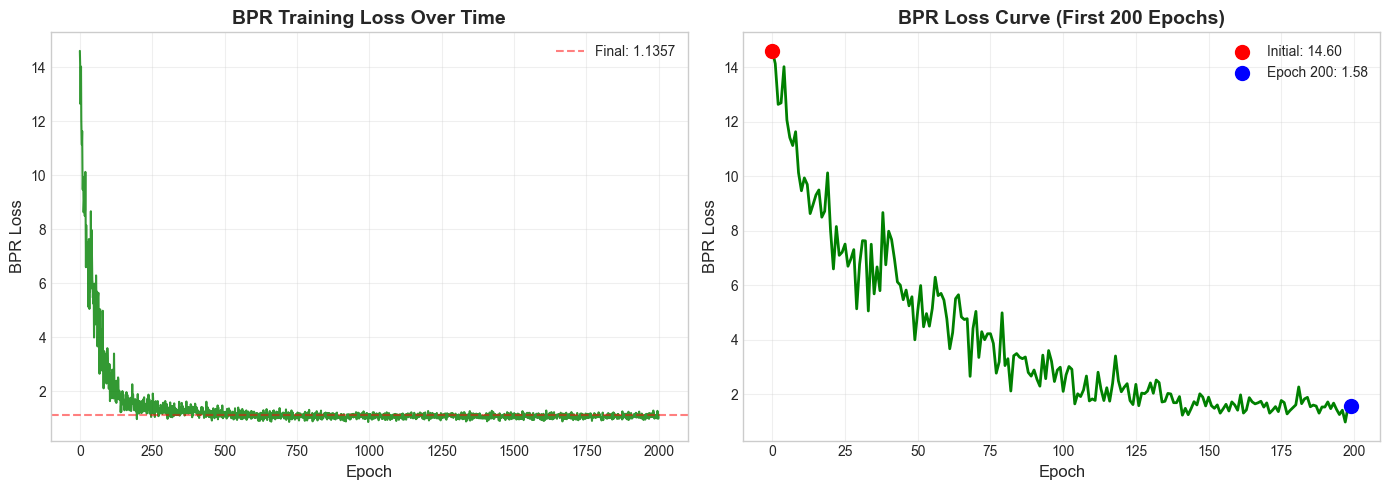

📉 BPR Loss decreased by 92.2% during training


In [13]:
# Plot BPR training loss curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full loss curve
ax1 = axes[0]
ax1.plot(bpr_loss_history, 'g-', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('BPR Loss', fontsize=12)
ax1.set_title('BPR Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.axhline(y=bpr_loss_history[-1], color='r', linestyle='--', alpha=0.5, label=f'Final: {bpr_loss_history[-1]:.4f}')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Zoomed view of first 200 epochs
ax2 = axes[1]
ax2.plot(bpr_loss_history[:200], 'g-', linewidth=2)
ax2.scatter([0], [bpr_loss_history[0]], color='red', s=100, zorder=5, label=f'Initial: {bpr_loss_history[0]:.2f}')
ax2.scatter([199], [bpr_loss_history[199]], color='blue', s=100, zorder=5, label=f'Epoch 200: {bpr_loss_history[199]:.2f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('BPR Loss', fontsize=12)
ax2.set_title('BPR Loss Curve (First 200 Epochs)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📉 BPR Loss decreased by {((bpr_loss_history[0] - bpr_loss_history[-1])/bpr_loss_history[0]*100):.1f}% during training")

## 9. Visualize BPR Rankings and Gradient Dynamics

Let's examine:
1. The ranked item lists for each user
2. How the gradient coefficient $(\sigma(x_{uij}) - 1)$ varies with score difference
3. Score differences before and after training

In [14]:
# Compute and display item rankings for each user
print("=" * 80)
print("BPR ITEM RANKINGS FOR EACH USER")
print("=" * 80)

R_hat_bpr = P_bpr_trained @ Q_bpr_trained.T

for u in range(M):
    scores = R_hat_bpr[u]
    ranking = np.argsort(-scores)  # Sort in descending order
    
    pos_items = set(np.where(mask[u] == 1)[0])
    
    print(f"\n👤 U{u+1} - Item Ranking by Predicted Score:")
    print("   " + "-" * 60)
    print("   Rank  Item   Score    Type")
    print("   " + "-" * 60)
    
    for rank, item_idx in enumerate(ranking):
        item_type = "✅ Positive (interacted)" if item_idx in pos_items else "❌ Negative (not interacted)"
        print(f"   {rank+1:>4}   I{item_idx+1:<3}  {scores[item_idx]:>7.3f}   {item_type}")

print("\n" + "=" * 80)

BPR ITEM RANKINGS FOR EACH USER

👤 U1 - Item Ranking by Predicted Score:
   ------------------------------------------------------------
   Rank  Item   Score    Type
   ------------------------------------------------------------
      1   I1      3.649   ✅ Positive (interacted)
      2   I6      2.075   ✅ Positive (interacted)
      3   I3      2.068   ✅ Positive (interacted)
      4   I8      2.014   ✅ Positive (interacted)
      5   I2     -1.034   ❌ Negative (not interacted)
      6   I5     -1.185   ❌ Negative (not interacted)
      7   I4     -3.390   ❌ Negative (not interacted)
      8   I7     -3.775   ❌ Negative (not interacted)

👤 U2 - Item Ranking by Predicted Score:
   ------------------------------------------------------------
   Rank  Item   Score    Type
   ------------------------------------------------------------
      1   I7      3.752   ✅ Positive (interacted)
      2   I2      2.625   ✅ Positive (interacted)
      3   I4      2.436   ✅ Positive (interacted)
    

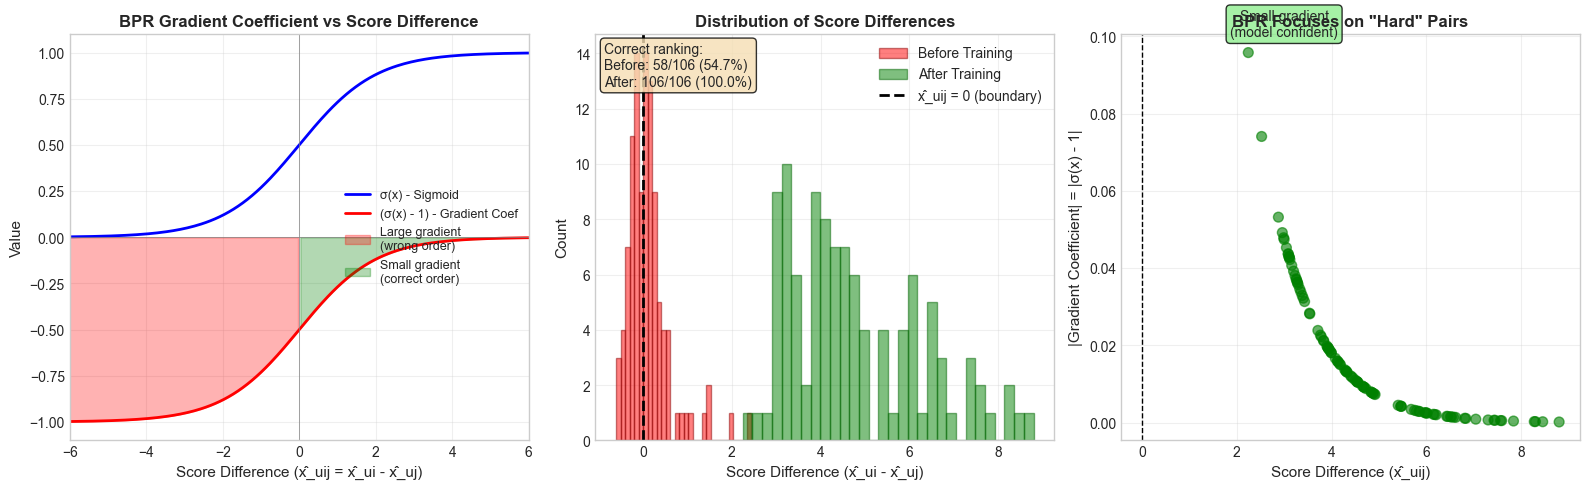

In [15]:
# Visualize gradient dynamics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Sigmoid function and gradient coefficient
ax1 = axes[0]
x = np.linspace(-6, 6, 200)
sig = sigmoid(x)
grad_coef = sig - 1

ax1.plot(x, sig, 'b-', linewidth=2, label='σ(x) - Sigmoid')
ax1.plot(x, grad_coef, 'r-', linewidth=2, label='(σ(x) - 1) - Gradient Coef')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax1.fill_between(x[x<0], grad_coef[x<0], alpha=0.3, color='red', label='Large gradient\n(wrong order)')
ax1.fill_between(x[x>0], grad_coef[x>0], alpha=0.3, color='green', label='Small gradient\n(correct order)')
ax1.set_xlabel('Score Difference (x̂_uij = x̂_ui - x̂_uj)', fontsize=11)
ax1.set_ylabel('Value', fontsize=11)
ax1.set_title('BPR Gradient Coefficient vs Score Difference', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.1, 1.1)

# Plot 2: Score differences distribution after training
ax2 = axes[1]

# Compute score differences for all triplets (sample)
np.random.seed(123)
sample_size = min(200, len(all_triplets))
sample_indices = np.random.choice(len(all_triplets), sample_size, replace=False)
sample_triplets = [all_triplets[i] for i in sample_indices]

score_diffs_initial = []
score_diffs_trained = []

# Initial (random) matrices
np.random.seed(42)
P_init = np.random.randn(M, K) * 0.5
Q_init = np.random.randn(N, K) * 0.5

for (u, i, j) in sample_triplets:
    # Initial
    x_ui_init = np.dot(P_init[u], Q_init[i])
    x_uj_init = np.dot(P_init[u], Q_init[j])
    score_diffs_initial.append(x_ui_init - x_uj_init)
    
    # Trained
    x_ui_trained = np.dot(P_bpr_trained[u], Q_bpr_trained[i])
    x_uj_trained = np.dot(P_bpr_trained[u], Q_bpr_trained[j])
    score_diffs_trained.append(x_ui_trained - x_uj_trained)

ax2.hist(score_diffs_initial, bins=30, alpha=0.5, color='red', label='Before Training', edgecolor='darkred')
ax2.hist(score_diffs_trained, bins=30, alpha=0.5, color='green', label='After Training', edgecolor='darkgreen')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='x̂_uij = 0 (boundary)')
ax2.set_xlabel('Score Difference (x̂_ui - x̂_uj)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Distribution of Score Differences', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotation
correct_before = sum(1 for d in score_diffs_initial if d > 0)
correct_after = sum(1 for d in score_diffs_trained if d > 0)
ax2.text(0.02, 0.98, f'Correct ranking:\nBefore: {correct_before}/{sample_size} ({100*correct_before/sample_size:.1f}%)\nAfter: {correct_after}/{sample_size} ({100*correct_after/sample_size:.1f}%)', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 3: Gradient magnitude for sample triplets
ax3 = axes[2]
grad_magnitudes = [np.abs(sigmoid(d) - 1) for d in score_diffs_trained]
colors = ['green' if d > 0 else 'red' for d in score_diffs_trained]

ax3.scatter(score_diffs_trained, grad_magnitudes, c=colors, alpha=0.6, s=50)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Score Difference (x̂_uij)', fontsize=11)
ax3.set_ylabel('|Gradient Coefficient| = |σ(x) - 1|', fontsize=11)
ax3.set_title('BPR Focuses on "Hard" Pairs', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add explanatory annotation
ax3.annotate('Large gradient\n(model uncertain)', xy=(-0.5, 0.45), fontsize=10, ha='center',
            bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.8))
ax3.annotate('Small gradient\n(model confident)', xy=(3, 0.1), fontsize=10, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

## 10. Compare MF vs BPR Results

Let's compare the predictions and rankings from both models side-by-side.

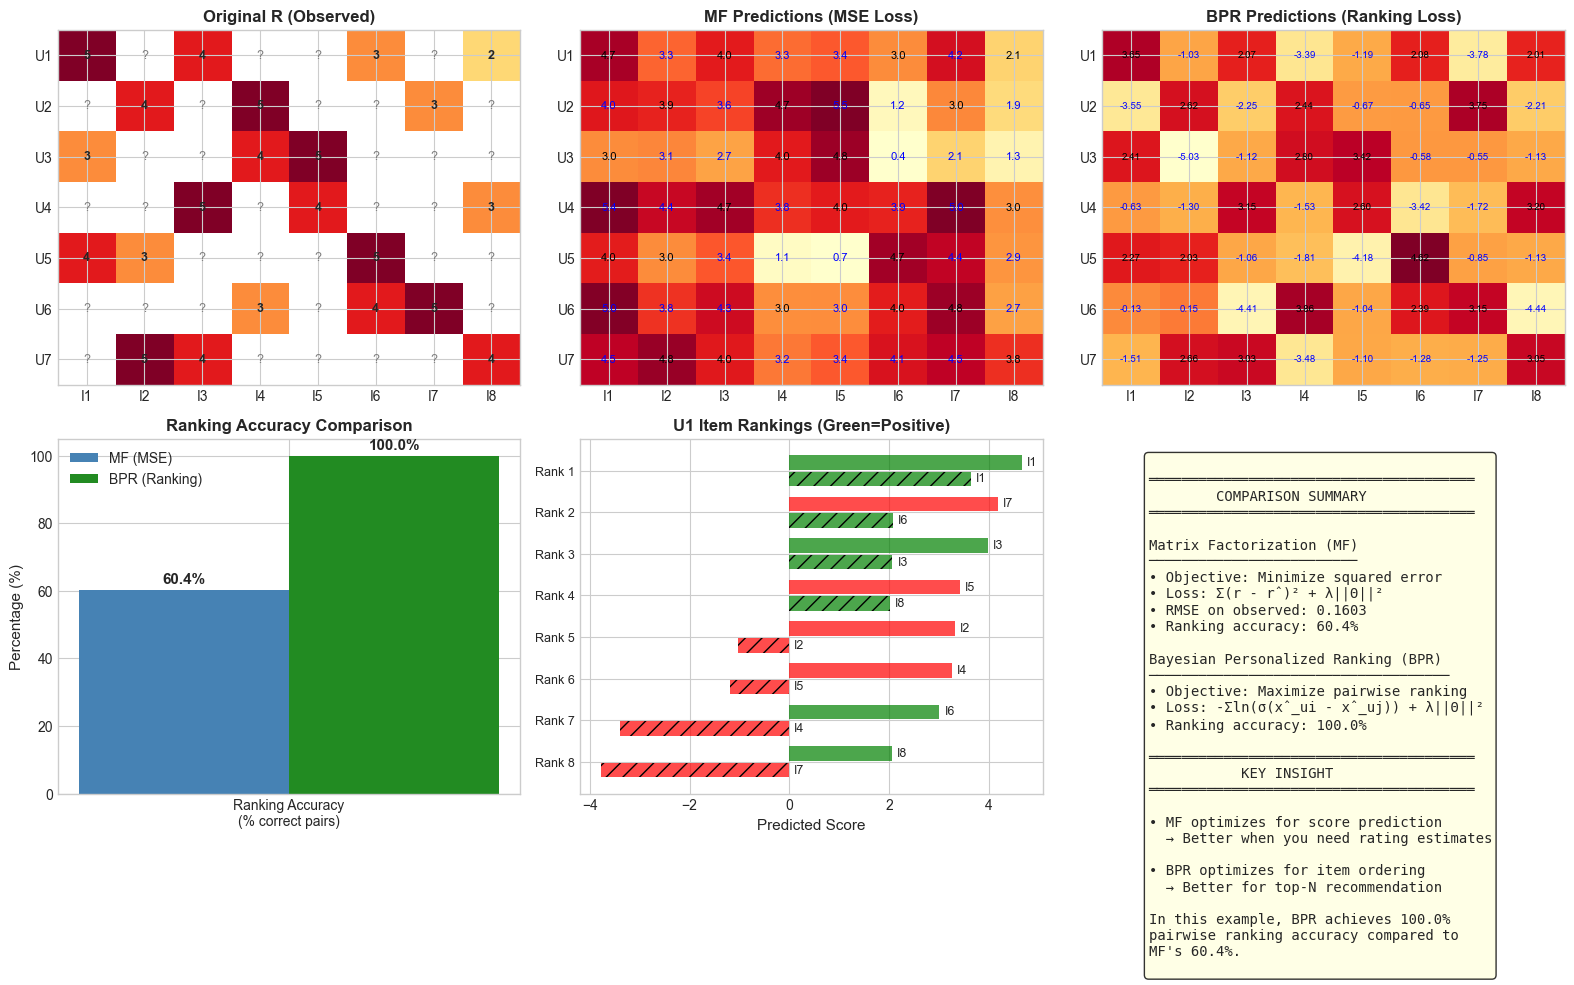

In [16]:
# Compare MF and BPR predictions
R_hat_mf = predict_mf(P_trained, Q_trained)
R_hat_bpr = P_bpr_trained @ Q_bpr_trained.T

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Heatmaps
# Original R
ax1 = axes[0, 0]
R_display = np.where(R == 0, np.nan, R)
im1 = ax1.imshow(R_display, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax1.set_xticks(range(N))
ax1.set_yticks(range(M))
ax1.set_xticklabels(items, fontsize=10)
ax1.set_yticklabels(users, fontsize=10)
ax1.set_title('Original R (Observed)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        if R[i, j] != 0:
            ax1.text(j, i, f'{int(R[i,j])}', ha='center', va='center', fontsize=9, fontweight='bold')
        else:
            ax1.text(j, i, '?', ha='center', va='center', fontsize=9, color='gray')

# MF predictions
ax2 = axes[0, 1]
im2 = ax2.imshow(R_hat_mf, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax2.set_xticks(range(N))
ax2.set_yticks(range(M))
ax2.set_xticklabels(items, fontsize=10)
ax2.set_yticklabels(users, fontsize=10)
ax2.set_title('MF Predictions (MSE Loss)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        color = 'blue' if mask[i, j] == 0 else 'black'
        ax2.text(j, i, f'{R_hat_mf[i,j]:.1f}', ha='center', va='center', fontsize=8, color=color)

# BPR predictions (normalized for visualization)
ax3 = axes[0, 2]
# Normalize BPR scores to similar range for comparison
R_hat_bpr_norm = (R_hat_bpr - R_hat_bpr.min()) / (R_hat_bpr.max() - R_hat_bpr.min()) * 4 + 1
im3 = ax3.imshow(R_hat_bpr_norm, cmap='YlOrRd', aspect='auto', vmin=1, vmax=5)
ax3.set_xticks(range(N))
ax3.set_yticks(range(M))
ax3.set_xticklabels(items, fontsize=10)
ax3.set_yticklabels(users, fontsize=10)
ax3.set_title('BPR Predictions (Ranking Loss)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        color = 'blue' if mask[i, j] == 0 else 'black'
        ax3.text(j, i, f'{R_hat_bpr[i,j]:.2f}', ha='center', va='center', fontsize=7, color=color)

# Row 2: Ranking comparison
# Compute ranking metrics
def compute_ranking_accuracy(R_hat, mask):
    """For each user, check if positive items are ranked higher than negative items"""
    correct = 0
    total = 0
    for u in range(M):
        pos_items = np.where(mask[u] == 1)[0]
        neg_items = np.where(mask[u] == 0)[0]
        for i in pos_items:
            for j in neg_items:
                total += 1
                if R_hat[u, i] > R_hat[u, j]:
                    correct += 1
    return correct / total if total > 0 else 0

mf_rank_acc = compute_ranking_accuracy(R_hat_mf, mask)
bpr_rank_acc = compute_ranking_accuracy(R_hat_bpr, mask)

# Ranking comparison bar chart
ax4 = axes[1, 0]
metrics = ['Ranking Accuracy\n(% correct pairs)']
mf_vals = [mf_rank_acc * 100]
bpr_vals = [bpr_rank_acc * 100]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax4.bar(x - width/2, mf_vals, width, label='MF (MSE)', color='steelblue')
bars2 = ax4.bar(x + width/2, bpr_vals, width, label='BPR (Ranking)', color='forestgreen')
ax4.set_ylabel('Percentage (%)', fontsize=11)
ax4.set_title('Ranking Accuracy Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, fontsize=10)
ax4.legend(fontsize=10)
ax4.set_ylim(0, 105)
for bar, val in zip(bars1, mf_vals):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars2, bpr_vals):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Side-by-side ranking for one user (U1)
ax5 = axes[1, 1]
u = 0  # U1
mf_ranking = np.argsort(-R_hat_mf[u])
bpr_ranking = np.argsort(-R_hat_bpr[u])
pos_items_u = set(np.where(mask[u] == 1)[0])

y_pos = np.arange(N)
mf_colors = ['green' if i in pos_items_u else 'red' for i in mf_ranking]
bpr_colors = ['green' if i in pos_items_u else 'red' for i in bpr_ranking]

ax5.barh(y_pos - 0.2, [R_hat_mf[u, i] for i in mf_ranking], 0.35, color=mf_colors, alpha=0.7, label='MF')
ax5.barh(y_pos + 0.2, [R_hat_bpr[u, i] for i in bpr_ranking], 0.35, color=bpr_colors, alpha=0.7, label='BPR', hatch='//')
ax5.set_yticks(y_pos)
ax5.set_yticklabels([f'Rank {i+1}' for i in range(N)], fontsize=9)
ax5.invert_yaxis()
ax5.set_xlabel('Predicted Score', fontsize=11)
ax5.set_title(f'U1 Item Rankings (Green=Positive)', fontsize=12, fontweight='bold')

# Add item labels
for idx, (mf_idx, bpr_idx) in enumerate(zip(mf_ranking, bpr_ranking)):
    ax5.text(R_hat_mf[u, mf_idx] + 0.1, idx - 0.2, f'I{mf_idx+1}', va='center', fontsize=9)
    ax5.text(max(0.1, R_hat_bpr[u, bpr_idx] + 0.1), idx + 0.2, f'I{bpr_idx+1}', va='center', fontsize=9)

# Summary text
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = f"""
═══════════════════════════════════════
        COMPARISON SUMMARY
═══════════════════════════════════════

Matrix Factorization (MF)
─────────────────────────
• Objective: Minimize squared error
• Loss: Σ(r - r̂)² + λ||Θ||²
• RMSE on observed: {compute_rmse(R, P_trained, Q_trained, mask):.4f}
• Ranking accuracy: {mf_rank_acc*100:.1f}%

Bayesian Personalized Ranking (BPR)
────────────────────────────────────
• Objective: Maximize pairwise ranking
• Loss: -Σln(σ(x̂_ui - x̂_uj)) + λ||Θ||²
• Ranking accuracy: {bpr_rank_acc*100:.1f}%

═══════════════════════════════════════
           KEY INSIGHT
═══════════════════════════════════════

• MF optimizes for score prediction
  → Better when you need rating estimates

• BPR optimizes for item ordering
  → Better for top-N recommendation

In this example, BPR achieves {bpr_rank_acc*100:.1f}%
pairwise ranking accuracy compared to
MF's {mf_rank_acc*100:.1f}%.
"""
ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

---
## 11. Result Interpretation and Analysis

### Summary of Numerical Results

In [17]:
# Comprehensive analysis and interpretation
print("═" * 80)
print("                    COMPREHENSIVE RESULT ANALYSIS")
print("═" * 80)

# 1. Data Statistics
print("\n📊 1. DATA STATISTICS")
print("-" * 80)
print(f"   • Matrix dimensions: {M} users × {N} items = {M*N} total entries")
print(f"   • Observed entries: {int(np.sum(mask))} ({100*np.sum(mask)/(M*N):.1f}%)")
print(f"   • Missing entries: {int(M*N - np.sum(mask))} ({100*(1-np.sum(mask)/(M*N)):.1f}%)")
print(f"   • Average rating: {np.mean(R[R>0]):.2f} (on observed entries)")
print(f"   • Rating range: {int(R[R>0].min())} to {int(R[R>0].max())}")

# 2. MF Analysis
print("\n📈 2. MATRIX FACTORIZATION ANALYSIS")
print("-" * 80)
print(f"   Latent Factors (K): {K}")
print(f"   Training epochs: {n_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Regularization λ: {lambda_reg}")
print(f"\n   Training Results:")
print(f"   • Initial loss: {loss_history[0]:.4f}")
print(f"   • Final loss: {loss_history[-1]:.4f}")
print(f"   • Loss reduction: {((loss_history[0]-loss_history[-1])/loss_history[0]*100):.1f}%")
print(f"   • Final RMSE: {compute_rmse(R, P_trained, Q_trained, mask):.4f}")
print(f"   • Ranking accuracy: {mf_rank_acc*100:.1f}%")

# Show reconstruction quality
print(f"\n   Reconstruction Quality (sample entries):")
sample_pairs = [(0,0), (0,2), (1,1), (2,4), (3,2)]
for u, i in sample_pairs:
    if mask[u, i] == 1:
        print(f"   • r({users[u]}, {items[i]}) = {int(R[u,i])}, r̂ = {R_hat_mf[u,i]:.2f}, error = {abs(R[u,i]-R_hat_mf[u,i]):.2f}")

# 3. BPR Analysis
print("\n📈 3. BPR ANALYSIS")
print("-" * 80)
print(f"   Total possible triplets: {len(all_triplets)}")
print(f"   Training epochs: {n_epochs_bpr}")
print(f"   Learning rate: {lr_bpr}")
print(f"   Regularization λ: {lambda_bpr}")
print(f"\n   Training Results:")
print(f"   • Initial loss: {bpr_loss_history[0]:.4f}")
print(f"   • Final loss: {bpr_loss_history[-1]:.4f}")
print(f"   • Loss reduction: {((bpr_loss_history[0]-bpr_loss_history[-1])/bpr_loss_history[0]*100):.1f}%")
print(f"   • Ranking accuracy: {bpr_rank_acc*100:.1f}%")

# 4. User-level analysis
print("\n👥 4. USER-LEVEL ANALYSIS")
print("-" * 80)
for u in range(M):
    pos_items = np.where(mask[u] == 1)[0]
    neg_items = np.where(mask[u] == 0)[0]
    
    # MF ranking for this user
    mf_scores = R_hat_mf[u]
    mf_ranking = np.argsort(-mf_scores)
    
    # BPR ranking for this user
    bpr_scores = R_hat_bpr[u]
    bpr_ranking = np.argsort(-bpr_scores)
    
    # Count how many positive items are in top-k
    def hits_at_k(ranking, pos_set, k):
        return len(set(ranking[:k]) & pos_set)
    
    mf_hits_3 = hits_at_k(mf_ranking, set(pos_items), 3)
    bpr_hits_3 = hits_at_k(bpr_ranking, set(pos_items), 3)
    
    print(f"\n   {users[u]}:")
    print(f"      Positive items: {[items[i] for i in pos_items]}")
    print(f"      MF Top-3: {[items[i] for i in mf_ranking[:3]]} → Hits@3 = {mf_hits_3}/{min(3, len(pos_items))}")
    print(f"      BPR Top-3: {[items[i] for i in bpr_ranking[:3]]} → Hits@3 = {bpr_hits_3}/{min(3, len(pos_items))}")

# 5. Key Insights
print("\n" + "═" * 80)
print("💡 KEY INSIGHTS FROM THIS NUMERICAL EXAMPLE")
print("═" * 80)
print("""
1. LATENT SPACE INTERPRETATION
   • K=3 latent factors capture user preferences and item characteristics
   • Users with similar latent vectors have similar tastes
   • Items with similar latent vectors are perceived similarly by users

2. MF vs BPR TRADE-OFFS
   • MF: Better at predicting actual rating values (lower RMSE)
   • BPR: Better at ranking items correctly (higher pairwise accuracy)
   • Choose based on application: rating prediction vs. top-N recommendation

3. GRADIENT DYNAMICS
   • MF: Gradient ∝ prediction error (e = r - r̂)
   • BPR: Gradient ∝ (σ(x_uij) - 1), focuses on "hard" pairs
   
4. SPARSITY HANDLING
   • Both methods can predict for ALL user-item pairs
   • Regularization prevents overfitting to sparse observed data
   
5. SCALABILITY CONSIDERATIONS
   • MF: O(|observed| × K) per epoch
   • BPR: O(|observed| × K) with negative sampling
   • Both scale linearly with observations
""")
print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
                    COMPREHENSIVE RESULT ANALYSIS
════════════════════════════════════════════════════════════════════════════════

📊 1. DATA STATISTICS
--------------------------------------------------------------------------------
   • Matrix dimensions: 7 users × 8 items = 56 total entries
   • Observed entries: 22 (39.3%)
   • Missing entries: 34 (60.7%)
   • Average rating: 3.95 (on observed entries)
   • Rating range: 2 to 5

📈 2. MATRIX FACTORIZATION ANALYSIS
--------------------------------------------------------------------------------
   Latent Factors (K): 3
   Training epochs: 1000
   Learning rate: 0.01
   Regularization λ: 0.1

   Training Results:
   • Initial loss: 346.3018
   • Final loss: 7.5705
   • Loss reduction: 97.8%
   • Final RMSE: 0.1603
   • Ranking accuracy: 60.4%

   Reconstruction Quality (sample entries):
   • r(U1, I1) = 5, r̂ = 4.66, error = 0.34
   • r(U1, I3) = 4, r̂ = 

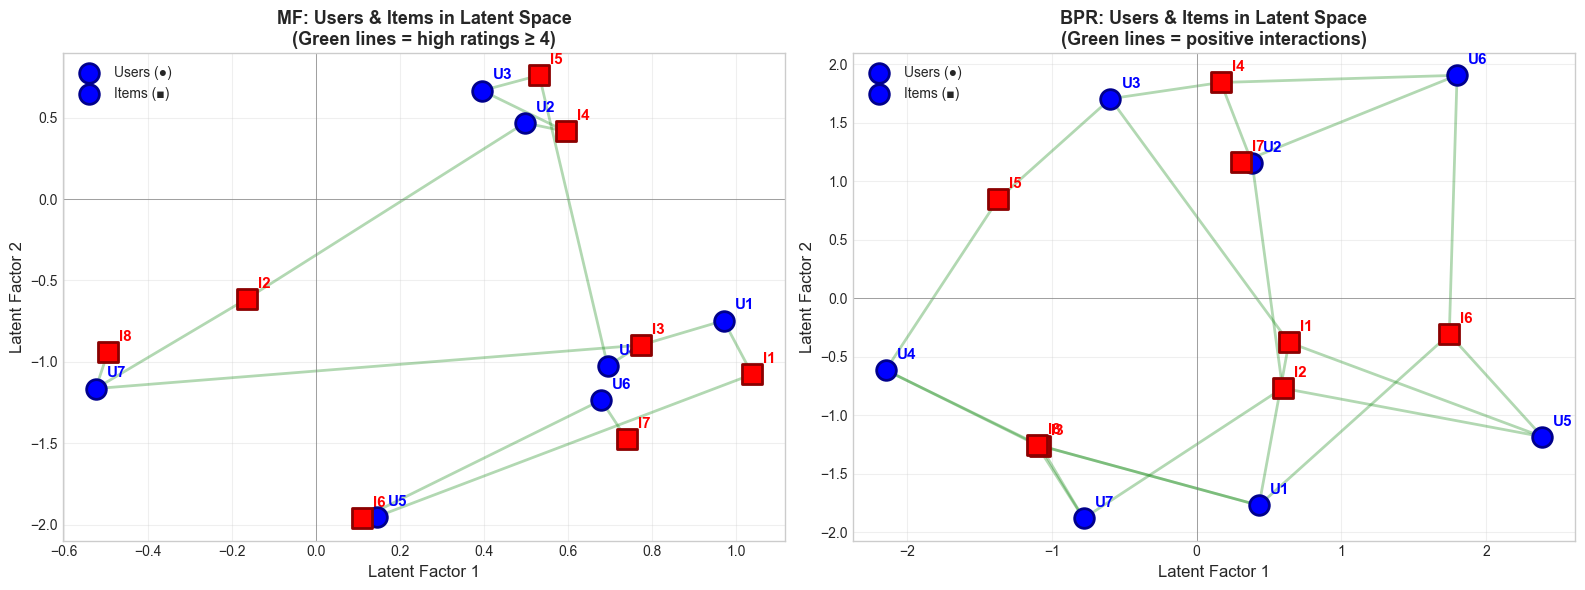


📌 Interpretation: In the latent space, users are positioned closer to items they prefer.
   The dot product between user and item vectors determines the predicted score/ranking.


In [18]:
# Final visualization: Latent space interpretation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MF Latent Space (3D projection to 2D using first 2 factors)
ax1 = axes[0]

# Plot users
for i, user in enumerate(users):
    ax1.scatter(P_trained[i, 0], P_trained[i, 1], c='blue', s=200, marker='o', 
               edgecolor='darkblue', linewidth=2, zorder=5)
    ax1.annotate(user, (P_trained[i, 0], P_trained[i, 1]), xytext=(8, 8), 
                textcoords='offset points', fontsize=11, fontweight='bold', color='blue')

# Plot items
for i, item in enumerate(items):
    ax1.scatter(Q_trained[i, 0], Q_trained[i, 1], c='red', s=200, marker='s', 
               edgecolor='darkred', linewidth=2, zorder=5)
    ax1.annotate(item, (Q_trained[i, 0], Q_trained[i, 1]), xytext=(8, 8), 
                textcoords='offset points', fontsize=11, fontweight='bold', color='red')

# Draw lines for high-rated interactions
for u in range(M):
    for i in range(N):
        if R[u, i] >= 4:  # Draw line for ratings >= 4
            ax1.plot([P_trained[u, 0], Q_trained[i, 0]], 
                    [P_trained[u, 1], Q_trained[i, 1]], 
                    'g-', alpha=0.3, linewidth=2)

ax1.set_xlabel('Latent Factor 1', fontsize=12)
ax1.set_ylabel('Latent Factor 2', fontsize=12)
ax1.set_title('MF: Users & Items in Latent Space\n(Green lines = high ratings ≥ 4)', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3)
ax1.legend(['Users (●)', 'Items (■)'], loc='upper left', fontsize=10)

# BPR Latent Space
ax2 = axes[1]

# Plot users
for i, user in enumerate(users):
    ax2.scatter(P_bpr_trained[i, 0], P_bpr_trained[i, 1], c='blue', s=200, marker='o', 
               edgecolor='darkblue', linewidth=2, zorder=5)
    ax2.annotate(user, (P_bpr_trained[i, 0], P_bpr_trained[i, 1]), xytext=(8, 8), 
                textcoords='offset points', fontsize=11, fontweight='bold', color='blue')

# Plot items
for i, item in enumerate(items):
    ax2.scatter(Q_bpr_trained[i, 0], Q_bpr_trained[i, 1], c='red', s=200, marker='s', 
               edgecolor='darkred', linewidth=2, zorder=5)
    ax2.annotate(item, (Q_bpr_trained[i, 0], Q_bpr_trained[i, 1]), xytext=(8, 8), 
                textcoords='offset points', fontsize=11, fontweight='bold', color='red')

# Draw lines for positive interactions
for u in range(M):
    for i in range(N):
        if mask[u, i] == 1:  # Draw line for any positive interaction
            ax2.plot([P_bpr_trained[u, 0], Q_bpr_trained[i, 0]], 
                    [P_bpr_trained[u, 1], Q_bpr_trained[i, 1]], 
                    'g-', alpha=0.3, linewidth=2)

ax2.set_xlabel('Latent Factor 1', fontsize=12)
ax2.set_ylabel('Latent Factor 2', fontsize=12)
ax2.set_title('BPR: Users & Items in Latent Space\n(Green lines = positive interactions)', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3)
ax2.legend(['Users (●)', 'Items (■)'], loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📌 Interpretation: In the latent space, users are positioned closer to items they prefer.")
print("   The dot product between user and item vectors determines the predicted score/ranking.")

## 12. Conclusions

### What We Learned

This numerical tutorial demonstrated the mathematical foundations of two fundamental latent factor models:

#### Matrix Factorization (MF)
- **Decomposes** the sparse user-item matrix $R$ into $P \times Q^T$
- **Optimizes** squared reconstruction error (pointwise loss)
- **Predicts** actual rating values
- **Best for**: Applications where accurate rating prediction is important

#### Bayesian Personalized Ranking (BPR)
- **Transforms** data into pairwise preference triplets $(u, i, j)$
- **Optimizes** pairwise ranking loss with sigmoid likelihood
- **Learns** to order items correctly rather than predict exact scores
- **Best for**: Top-N recommendation where ranking matters most

### Key Takeaways

1. **Latent factors** provide a compact representation of user preferences and item characteristics
2. **Regularization** is essential to prevent overfitting on sparse data
3. **The choice of loss function** (MSE vs. BPR) depends on your application goal
4. **Negative sampling** makes BPR computationally tractable for large datasets
5. Both methods form the **foundation for modern neural recommenders** and Graph Neural Networks

---
*This tutorial used a toy example with 7 users and 8 items. Real-world systems scale to millions of users and items using distributed computing and more sophisticated optimization techniques.*